## Initialization

In [1]:
import pandas as pd
import numpy as np
import os, sys
from PIL import Image

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
faces = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# shape
faces.shape

(7591, 2)

In [4]:
# top 5
faces.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# duplicates?
faces.duplicated().sum()

0

In [6]:
# missing?
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
# 5 point summary
faces.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Conclusion There are 7591 faces in the dataset. There are no missing values or duplicates, the mean age of a person is 31 and the ages range from 1 to 100 years.

## EDA

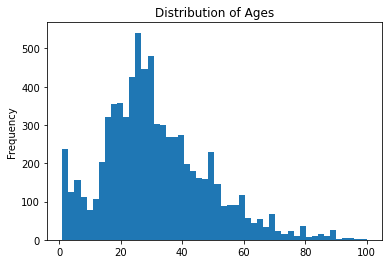

In [8]:
faces['real_age'].plot(kind='hist', title='Distribution of Ages', bins=50)
plt.show()

The distribution looks like it is right skewed and it peaks at around 24 theres also around 1 24 and it looks like it spikes again around 50.

In [9]:
def plot_images(df, path, num=10, is_generator=False, img_datagen=None):
    """
    Plot a series of images
    """
    plt.figure(figsize=(10, 10))
    if not is_generator:
        sample_faces = df['file_name'].sample(n=num)
    else:
        sample_faces, _ = img_datagen
        sample_faces = sample_faces[:num]
    for idx, file in enumerate(sample_faces):
        # with open(os.path.join(path, file), 'rb') as f:
        plt.subplot(2, 5, idx+1)
        if not is_generator:
            img = Image.open(os.path.join(path, file))
            plt.imshow(np.array(img, dtype=np.uint8))
        else:
            img = file
            plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # plt.xlabel(f'{file}')

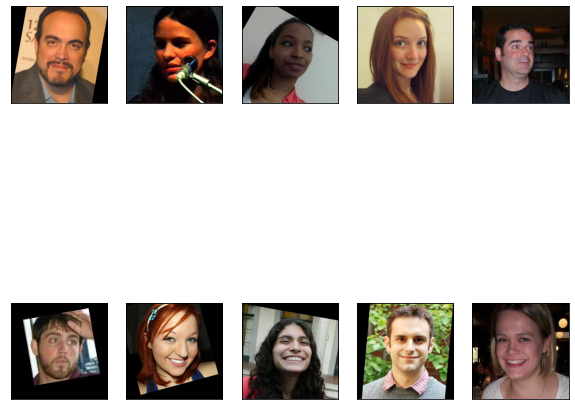

In [10]:
img_dir = r'/datasets/faces/final_files/'
plot_images(faces, img_dir)

### Findings

Findings The images are cropped some rotated there are other things in the background including poor lighting. Theres also majority one race being represented here.

In [11]:
datagen = ImageDataGenerator(rescale=1/255.,
                  horizontal_flip=True,
                  width_shift_range=.2,
                  zoom_range=0.2)
img_datagen = datagen.flow_from_dataframe(faces, 
                            x_col='file_name',
                            y_col='real_age',
                            directory=img_dir,
                            batch_size=32,
                            target_size=(150, 150),
                            class_mode='raw'
                           )
len(img_datagen)

Found 7591 validated image filenames.


238

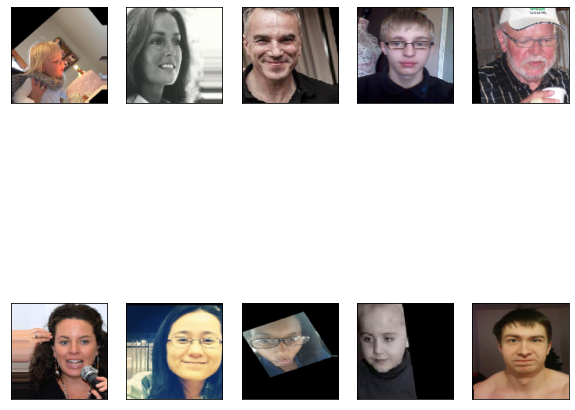

In [12]:
plot_images(faces, img_dir, is_generator=True, img_datagen=next(img_datagen))

There isn't much impact on the resulting images after applying horizontal_flip, width_shift_range and zoom_range augmentation techniques.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [13]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [14]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    img_dir = os.path.join(path, 'final_files/')
    # place your code here
    train_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=.2,
                            # zoom_range=0.2,
    )
    train_gen_flow = train_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=16,
                            class_mode='raw',
                            subset='training',
                            seed=42,
                            )

    return train_gen_flow

In [15]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    img_dir = os.path.join(path, 'final_files/')
    # place your code here
    test_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
    )
    test_gen_flow = test_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=16,
                            class_mode='raw',
                            subset='validation',
                            seed=42,
                            )

    return test_gen_flow

In [16]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.00002)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    

    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )
    
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [18]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [ ]:
if __name__ == '__main__':
    path = '/datasets/faces/'
    
    train_data = load_train(path)
    test_data = load_test(path)
    
    model = create_model(input_shape=(150, 150, 3))
    
    model = train_model(model, train_data, test_data, batch_size=32, epochs=20)
    

Found 6073 validated image filenames.
Found 1518 validated image filenames.


2023-11-08 21:32:10.978668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
380/380 - 81s - loss: 433.8839 - mae: 15.7607 - val_loss: 1142.4342 - val_mae: 29.2774
                
Epoch 2/20
380/380 - 63s - loss: 110.0558 - mae: 8.0040 - val_loss: 168.8695 - val_mae: 9.7129
                
Epoch 3/20
380/380 - 63s - loss: 77.2882 - mae: 6.7684 - val_loss: 91.6079 - val_mae: 7.0914
                
Epoch 4/20
380/380 - 63s - loss: 60.6527 - mae: 6.0478 - val_loss: 94.9320 - val_mae: 7.2080
                
Epoch 5/20
380/380 - 63s - loss: 51.1140 - mae: 5.5486 - val_loss: 88.4257 - val_mae: 7.2080
                
Epoch 6/20
380/380 - 63s - loss: 43.7908 - mae: 5.1675 - val_loss: 86.1508 - val_mae: 6.8944
                
Epoch 7/20
380/380 - 63s - loss: 37.5371 - mae: 4.7595 - val_loss: 84.8398 - val_mae: 6.9497
                
Epoch 8/20
380/380 - 63s - loss: 33.0117 - mae: 4.4585 - val_loss: 84.6479 - val_mae: 6.8816
                
Epoch 9/20
380/380 - 63s - loss: 29.7722 - mae: 4.2587 - val_loss: 92.5667 - val_mae: 7.0251
                
Epoch 10/20
380/380 - 63s - loss: 27.1025 - mae: 4.0468 - val_loss: 84.8264 - val_mae: 6.9448
                
Epoch 11/20
380/380 - 63s - loss: 23.1488 - mae: 3.7526 - val_loss: 80.2860 - val_mae: 6.6158
                
Epoch 12/20
380/380 - 63s - loss: 20.4797 - mae: 3.4981 - val_loss: 79.5077 - val_mae: 6.6164
                
Epoch 13/20
380/380 - 63s - loss: 18.0706 - mae: 3.3081 - val_loss: 85.8937 - val_mae: 6.8483
                
Epoch 14/20
380/380 - 63s - loss: 16.3230 - mae: 3.1203 - val_loss: 78.7336 - val_mae: 6.5299
                
Epoch 15/20
380/380 - 63s - loss: 13.9065 - mae: 2.8884 - val_loss: 83.6736 - val_mae: 6.7283
                
Epoch 16/20
380/380 - 63s - loss: 13.1962 - mae: 2.8132 - val_loss: 78.1952 - val_mae: 6.5339
                
Epoch 17/20
380/380 - 63s - loss: 11.9624 - mae: 2.6608 - val_loss: 78.0311 - val_mae: 6.4771
                
Epoch 18/20
380/380 - 63s - loss: 10.7823 - mae: 2.5450 - val_loss: 76.5776 - val_mae: 6.4873
                
Epoch 19/20
380/380 - 63s - loss: 10.3507 - mae: 2.4871 - val_loss: 74.1275 - val_mae: 6.4778
                
Epoch 20/20
380/380 - 63s - loss: 9.7373 - mae: 2.4102 - val_loss: 75.5010 - val_mae: 6.539
                

## Conclusions

Overall the model gets better over the 20 epochs. In Epoch 1 the training loss is extremely high at 433.88, and the mae is a 15.76. as training progresses the loss and mae decrease significantly. by Epoch 20 the training loss is way lower at 9.73 and the mae is down to a 2.41. As for the Validation loss and val mae its similar where the epoch 1 is extremely high at 1142.43 and the mae is 29.27 they both decrease as training continues by epoch 20 the validation loss is 75.50 and the validation mae is 6.53 which is way lower then the original epoch but still significantly high. the training loss and mae consistencely decrease which is positive and proves the model is improving and its makeing more accurate predictions. The validation loss and validation mae does the same but does not decrease as fast as the training metrics this may suggest the model is improving on performance but may not be generlizing as well as we hoped. sense there is such a gap it may suggest some overfitting. we do achieve a Mae score that is not higher then 8.

# Checklist

- [X]  Notebook was opened
- [X]  The code is error free
- [X]  The cells with code have been arranged by order of execution
- [X]  The exploratory data analysis has been performed
- [X]  The results of the exploratory data analysis are presented in the final notebook
- [X]  The model's MAE score is not higher than 8
- [X]  The model training code has been copied to the final notebook
- [X]  The model training output has been copied to the final notebook
- [X]  The findings have been provided based on the results of the model training